In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
sys.path.append('../')
from utils.my_utils import load_data
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
X, session_df, requests_df = load_data(csv_path='../dataset/output.log', req_thres=4, normalize_feat=True)

In [74]:
X['is_bot'] = X['is_bot'].astype(int)
X['is_pc'] = X['is_pc'].astype(int)

#X.reset_index(inplace=True)

to_model_cols = X.columns[:15]

X_train, X_test = train_test_split(X[to_model_cols], test_size=0.2, random_state=42)

print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (26760, 15)
X_test shape: (6691, 15)


In [75]:
X_train.columns

Index(['requests_count', 'path_length_std', '4xx_percentage(%)',
       '3xx_percentage(%)', 'HEAD_count(%)', 'image_count(%)',
       'total_response_length', 'mean_response_length', 'total_response_time',
       'mean_response_time', 'avg_path_count_norm', 'robots_txt_reqs',
       'is_bot', 'is_pc', 'avg_time_diff'],
      dtype='object')

In [48]:
X_test.drop(columns=['robots_txt_reqs'], inplace=True)

# Auto encoder model

In [76]:
input_dim = X_train.shape[1] # the # features
encoding_dim = input_dim # first layer
hidden_dim = int(encoding_dim / 2) #hidden layer


# model architecture
input_layer = Input(shape=(input_dim))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the model
autoencoder.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['acc'])

autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense_12 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_13 (Dense)             (None, 7)                 112       
_________________________________________________________________
dense_14 (Dense)             (None, 15)                120       
_________________________________________________________________
dense_15 (Dense)             (None, 15)                240       
Total params: 712
Trainable params: 712
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nb_epoch = 25
batch_size = 64

checkpoint_filepath = 'checkpoints/autoencoder_weights.h5'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    validation_data=(X_test, X_test),
                    verbose=1, callbacks=[model_checkpoint_callback])

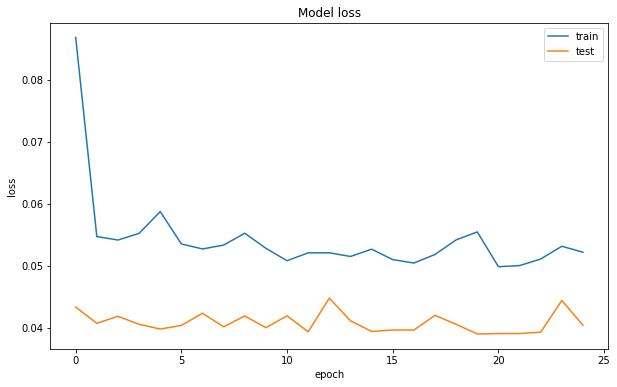

In [111]:
fig = plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [38]:
X_train.drop(columns=['mse'], axis=1, inplace=True)
X_test.drop(columns=['mse'], axis=1, inplace=True)

## Load the model

In [77]:
# load the best weights
checkpoint_filepath = 'checkpoints/autoencoder_weights_01.h5'
autoencoder.load_weights(checkpoint_filepath)

train_preds = autoencoder.predict(X_train)
test_preds = autoencoder.predict(X_test)

#get the error term
mse_train = np.mean(np.power(X_train.to_numpy() - train_preds, 2), axis=1)
mse_test = np.mean(np.power(X_test.to_numpy() - test_preds, 2), axis=1)

X_train['mse'] = mse_train
X_test['mse'] = mse_test

In [107]:
temp = X_test.reset_index()

temp[temp['user_agent'] == 'python-requests/2.18.1']

,ip,user_agent,requests_count,path_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%),image_count(%),total_response_length,mean_response_length,total_response_time,mean_response_time,avg_path_count_norm,robots_txt_reqs,is_bot,is_pc,avg_time_diff,mse
4425,21.101.108.189,python-requests/2.18.1,-0.10185,0.0,-0.106843,-0.011647,-0.020735,-1.414275,-0.012537,0.195661,-0.085798,-0.154116,2.122783,-0.041072,0,0,2.949293,0.719531


In [105]:
mse_threshold = np.quantile(X_train['mse'], 0.934)
print('mse threshold is {}'.format(mse_threshold))

train_outliers = session_df.loc[X_train[X_train['mse'] > mse_threshold].sort_values(['mse'], ascending=False).index]
train_inliers = session_df.loc[X_train[X_train['mse'] < mse_threshold].sort_values(['mse'], ascending=True).index]

print('train outliers shape: {}'.format(train_outliers.shape))
print('train inliers shape: {}'.format(train_inliers.shape))

mse threshold is 0.688746285588606
train outliers shape: (1767, 17)
train inliers shape: (24993, 17)


In [79]:
test_outliers = session_df.loc[X_test[X_test['mse'] > mse_threshold].sort_values(['mse'], ascending=False).index]
test_inliers = session_df.loc[X_test[X_test['mse'] < mse_threshold].sort_values(['mse'], ascending=True).index]

print('test outliers shape: {}'.format(test_outliers.shape))
print('test inliers shape: {}'.format(test_inliers.shape))

test outliers shape: (129, 17)
test inliers shape: (6562, 17)


In [52]:
#train_outliers.reset_index(inplace=True)

#ip = train_outliers.iloc[50].ip
#ua = train_outliers.iloc[50].user_agent

#ip = '134.172.55.99'
ua = 'python-requests/2.18.1' 

requests_df[(requests_df['user_agent'] == ua)].sort_values('time_stamp', ascending=True).head(20)

,ip,time,method,status_code,path,response_length,user_agent,response_time,path_count_normalized,path_length,time_stamp
86267,21.101.108.189,2021-05-12 06:13:05+04:30,Get,307,,0,python-requests/2.18.1,4.0,0.481101,1,1620783785
86275,21.101.108.189,2021-05-12 06:13:05+04:30,Get,200,877499224,63379,python-requests/2.18.1,28.0,2.670010,1,1620783785
86296,21.101.108.189,2021-05-12 06:13:06+04:30,Get,200,877499224,63379,python-requests/2.18.1,28.0,2.670010,1,1620783786
86315,21.101.108.189,2021-05-12 06:13:06+04:30,Get,200,877499224,63379,python-requests/2.18.1,36.0,2.670010,1,1620783786


In [109]:
f = train_outliers.reset_index()

f[f['user_agent'].str.contains('bot', case=False)].sort_values('requests_count', ascending=True)


,ip,user_agent,requests_count,path_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%),image_count(%),total_response_length,mean_response_length,total_response_time,mean_response_time,avg_path_count_norm,robots_txt_reqs,browser,os,is_bot,is_pc,avg_time_diff
1766,207.213.193.220,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,4,0.577350,0.000000,0.000000,0.0,25.000000,78059,19514.750000,24.0,6.000000,1.918224,0.0,Googlebot,Android,True,False,2.161048e+09
238,127.227.194.30,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,4,0.500000,75.000000,0.000000,0.0,75.000000,113012,28253.000000,16.0,4.000000,0.396274,0.0,FacebookBot,Mac OS X,True,True,2.161053e+09
237,35.40.15.137,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,4,0.500000,75.000000,0.000000,0.0,75.000000,113012,28253.000000,4.0,1.000000,0.396274,0.0,FacebookBot,Mac OS X,True,True,2.161071e+09
236,35.132.136.207,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,4,0.500000,75.000000,0.000000,0.0,75.000000,113012,28253.000000,32.0,8.000000,0.396274,0.0,FacebookBot,Mac OS X,True,True,2.161074e+09
235,86.0.202.195,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,4,0.500000,75.000000,0.000000,0.0,75.000000,113012,28253.000000,24.0,6.000000,0.396274,0.0,FacebookBot,Mac OS X,True,True,2.161084e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,207.213.207.158,Googlebot-Image/1.0,10113,0.214541,0.000000,99.406704,0.0,5.023237,2555158,252.660734,217869.0,21.543459,0.049879,0.0,Googlebot-Image,Other,True,False,1.620967e+09
5,207.213.193.143,Googlebot-Image/1.0,13320,0.337257,0.000000,98.791291,0.0,13.250751,6063491,455.217042,253764.0,19.051351,0.135301,0.0,Googlebot-Image,Other,True,False,1.620910e+09
4,207.213.207.144,Googlebot-Image/1.0,15363,0.208714,0.000000,99.401159,0.0,4.745167,4068097,264.798347,328300.0,21.369524,0.047027,0.0,Googlebot-Image,Other,True,False,1.620912e+09
3,207.213.207.130,Googlebot-Image/1.0,21494,0.214493,0.004652,99.390528,0.0,5.038615,6676080,310.602028,458280.0,21.321299,0.048361,0.0,Googlebot-Image,Other,True,False,1.620881e+09


# Human based evaluation

We decided to manually evaluate the predictions :) 

In [93]:
#outliers
outlier_index = train_outliers.set_index(['ip', 'user_agent'])[40:60].index
out_df = pd.DataFrame(index=outlier_index, columns={'label'}).fillna(-1)

#inliers
inlier_index = train_inliers.set_index(['ip', 'user_agent'])[60:90].index
in_df = pd.DataFrame(index=inlier_index, columns={'label'}).fillna(1)


dfs = [out_df, in_df]
merged_df = pd.concat(dfs)
merged_df = shuffle(merged_df, random_state=42)

# to save to the csv file in order to evaluate them manually later
merged_df.to_csv('mohammad.csv')

In [238]:
%matplotlib notebook

<IPython.core.display.Javascript object>


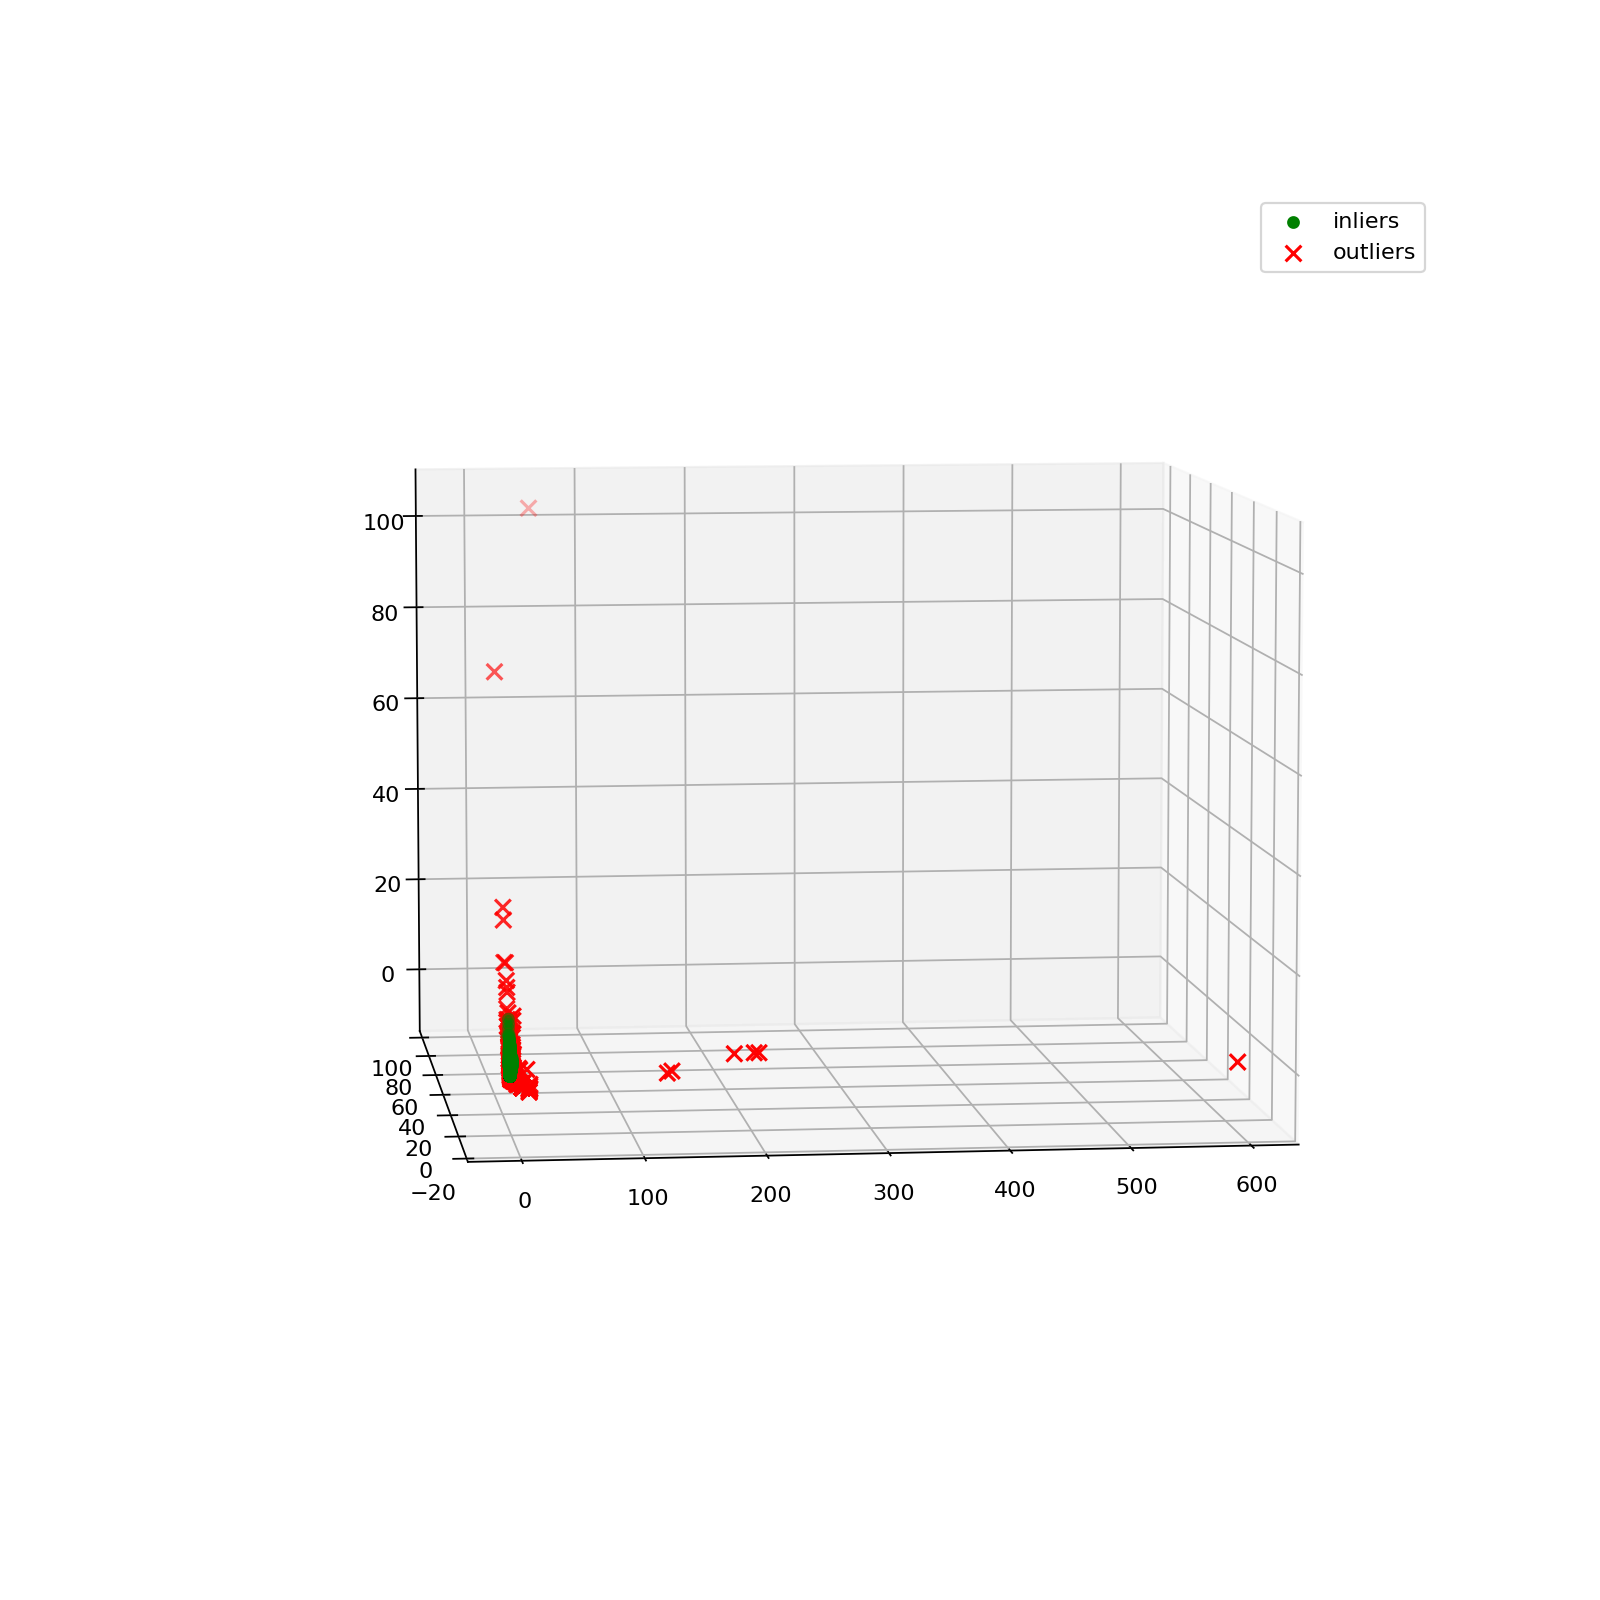

In [239]:
temp = X_train

temp.reset_index(inplace=True)
temp.drop(columns=['index'], inplace=True)


outlier_index = temp[temp['mse'] > mse_threshold].index
inlier_index = temp[temp['mse'] < mse_threshold].index


pca = PCA(n_components=3)  # Reduce to k=3 dimensions
X_reduce = pca.fit_transform(temp)

fig = plt.figure(figsize=(10,10), dpi=80)
ax = fig.add_subplot(111, projection='3d')

# Plot the compressed data points
ax.scatter(X_reduce[inlier_index, 0], X_reduce[inlier_index, 1], zs=X_reduce[inlier_index, 2], 
           s=14, lw=2, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=10, s=1, marker="x", c="red", label="outliers")

ax.legend()
plt.show()